c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset Shape: (1400, 3)
                                         Comment     Label Language
0                                   ইদুরের গর্তে  Negative   BANGLA
1                                     এরা এখন কই  Negative   BANGLA
2                                        আদু ভাই  Negative   BANGLA
3              সাদ্দাম তুই কই,,,?\nতোকে খুঁজতাছি  Negative   BANGLA
4  এখন দেখি বাংলাদেশে ছাত্রলীগের কোনো জায়গা নেই  Negative   BANGLA


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 280/280 [00:00<00:00, 6295.19 examples/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\USERAS\AppData\Local\Temp\ipykernel_36248\909414224.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.649500,0.617235,0.692857,0.585568
2,0.672300,0.617378,0.692857,0.567149
3,0.593700,0.622082,0.692857,0.567149
4,0.577800,0.617786,0.692857,0.567149
5,0.606800,0.627609,0.692857,0.567149
6,0.604400,0.616981,0.692857,0.567149
7,0.622900,0.616993,0.692857,0.567149
8,0.602300,0.618412,0.692857,0.567149
9,0.589400,0.617202,0.692857,0.567149
10,0.610600,0.617327,0.692857,0.567149


Evaluation results: {'eval_loss': 0.617327094078064, 'eval_accuracy': 0.6928571428571428, 'eval_f1': 0.5671488848704039, 'eval_runtime': 2.1485, 'eval_samples_per_second': 130.323, 'eval_steps_per_second': 8.378, 'epoch': 10.0}
Classification Report:
               precision    recall  f1-score   support

    Negative       0.69      1.00      0.82       194
    Positive       0.00      0.00      0.00        86

    accuracy                           0.69       280
   macro avg       0.35      0.50      0.41       280
weighted avg       0.48      0.69      0.57       280



c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


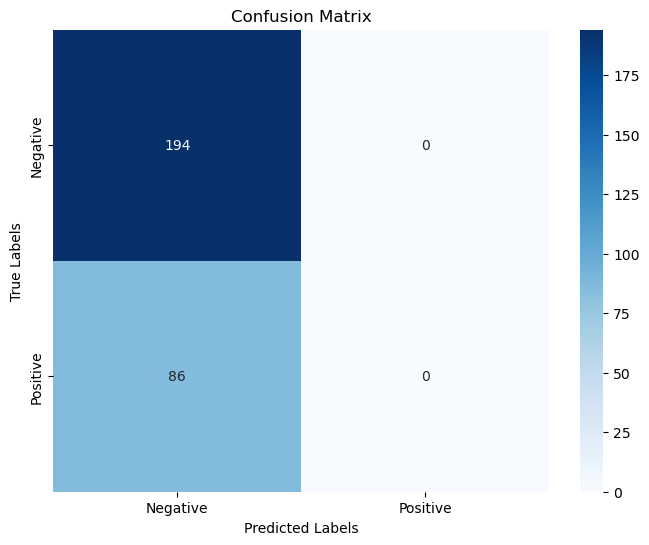

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# Load dataset
df = pd.read_csv("data/bangla_political_comments.csv")
print("Dataset Shape:", df.shape)
print(df.head())

# Check for missing values
df.dropna(inplace=True)

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract features and labels
X = df['Comment']
y = df['Label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to Hugging Face dataset
data = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
data = data.train_test_split(test_size=0.2, seed=42)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'albert/albert-base-v2'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

data = data.map(tokenize_function, batched=True)
data = data.remove_columns(['text']).rename_column('label', 'labels')
data.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='no',
    load_best_model_at_end=False,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Generate predictions
predictions_output = trainer.predict(data['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids

# Classification report
report = classification_report(labels, predictions, target_names=le.classes_)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
